In [1]:
import collections
import csv
import pathlib

import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# TODO: Clean up this mess.
import hier
from prepare_hierarchy import util

In [2]:
RESOURCES_DIR = pathlib.Path('resources')

In [3]:
# Load hierarchy.

with open(RESOURCES_DIR / 'hierarchy/tiny_imagenet_fiveai.csv') as f:
    tree, names = hier.make_hierarchy_from_edges(hier.load_edges(f))

In [4]:
g = nx.DiGraph()
g.add_edges_from(tree.edges())

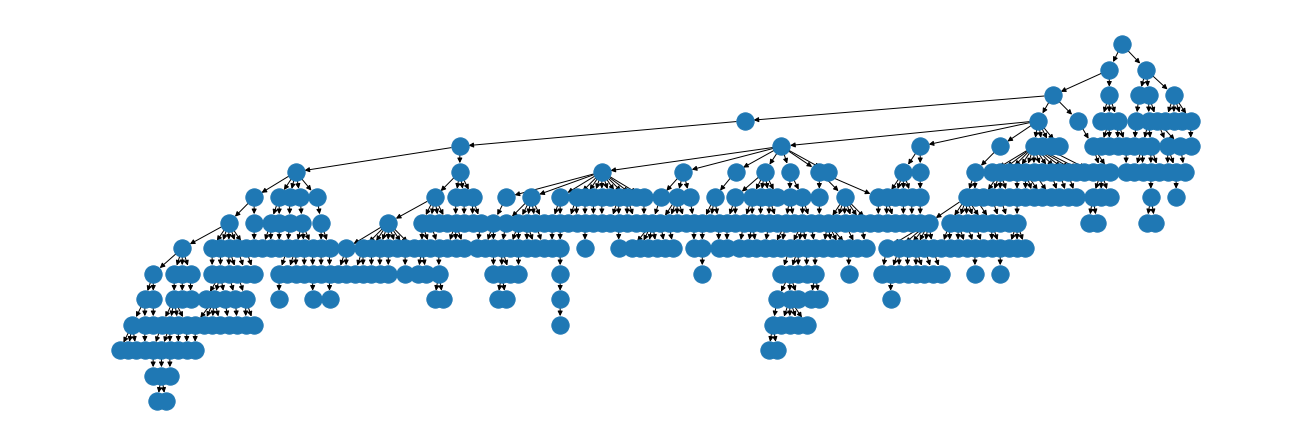

In [5]:
pos = graphviz_layout(g, prog='dot')
plt.figure(figsize=(18, 6))
nx.draw(g, pos)
plt.show()

In [6]:
g_original = g

In [7]:
# Remove trivial nodes (only-child).

def remove_trivial(g, root=0):
    h = nx.DiGraph()

    def visit(node, parent):
        children = list(g.successors(node))
        if not children:
            h.add_edge(parent, node)
        elif len(children) == 1:
            # Skip over only child.
            child, = children
            visit(child, parent)
        else:
            # Multiple children. Keep this node.
            h.add_edge(parent, node)
            for child in children:
                visit(child, node)

    for node in g.successors(root):
        visit(node, root)
    
    return h

g = remove_trivial(g)

In [8]:
len(g)

298

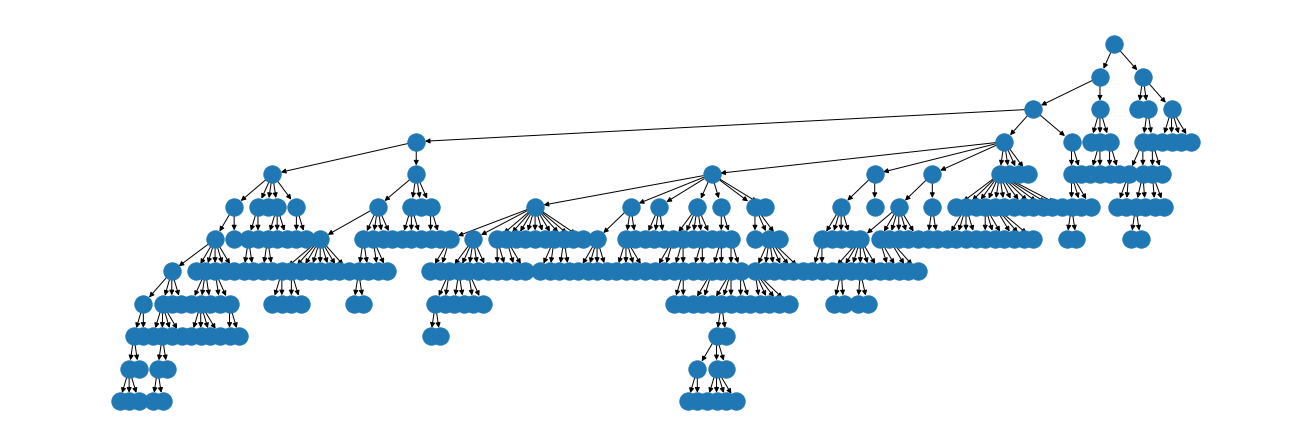

In [9]:
pos = graphviz_layout(g, prog='dot')
plt.figure(figsize=(18, 6))
nx.draw(g, pos)
plt.show()

In [10]:
# How many nodes have n children?
counts = collections.Counter(len(list(g.successors(x))) for x in g)
dict(sorted(counts.items()))

{0: 200, 2: 59, 3: 15, 4: 11, 5: 4, 6: 4, 7: 2, 8: 1, 12: 2}

In [11]:
g_full = g

In [12]:
# Trim hierarchy.

def trim(g, trim_threshold, keep_fraction, root=0):
    h = nx.DiGraph()

    def visit(node):
        children = sorted(g.successors(node))
        if len(children) >= trim_threshold:
            num_keep = int(round(keep_fraction * len(children)))
            print('keep {} of {}'.format(num_keep, len(children)))
            children = children[:num_keep]
        for child in children:
            h.add_edge(node, child)
            visit(child)

    visit(root)
    return h

g = trim(g, trim_threshold=4, keep_fraction=0.75)

keep 4 of 5
keep 4 of 6
keep 3 of 4
keep 3 of 4
keep 3 of 4
keep 3 of 4
keep 4 of 5
keep 6 of 8
keep 5 of 7
keep 5 of 7
keep 9 of 12
keep 4 of 5
keep 3 of 4
keep 3 of 4
keep 4 of 5
keep 3 of 4
keep 3 of 4
keep 4 of 6
keep 4 of 6
keep 9 of 12
keep 3 of 4
keep 3 of 4


In [13]:
len(g), sum(1 for x in g if not g.succ[x])

(247, 155)

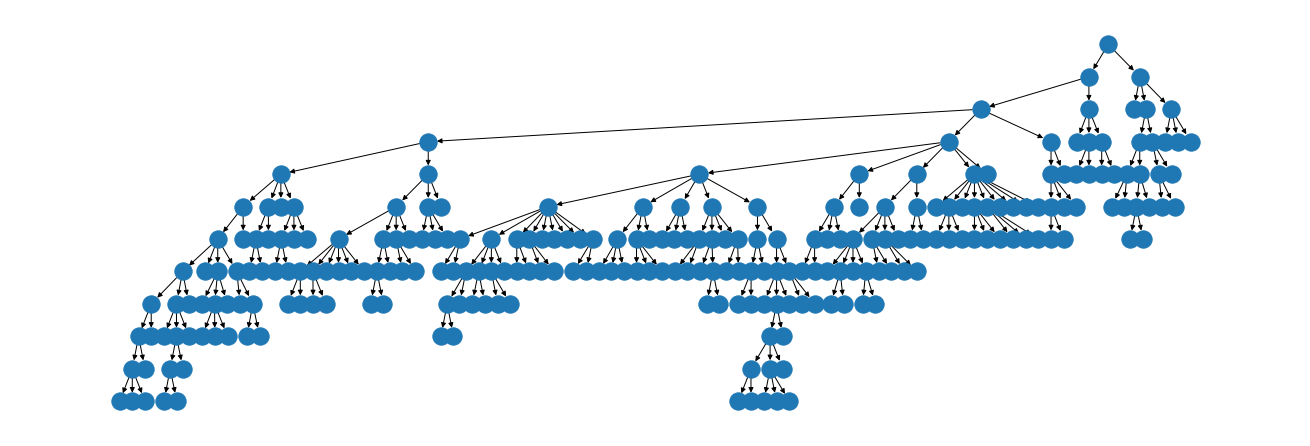

In [14]:
pos = graphviz_layout(g, prog='dot')
plt.figure(figsize=(18, 6))
nx.draw(g, pos)
plt.show()

In [15]:
leaf_order = sorted([x for x in g if not g.succ[x]])

In [16]:
index_edges = util.dfs_edges_with_order(g, leaf_order)
edges = [(names[i], names[j]) for i, j in index_edges]

In [17]:
# Write hierarchy to file.
with open(RESOURCES_DIR / 'hierarchy/tiny_imagenet_fiveai_incomplete.csv', 'w') as f:
    w = csv.writer(f)
    for edge in edges:
        w.writerow(edge)